# Imports

In [15]:
import json
import os

from datetime import datetime
import copy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision.transforms import ToTensor
from torchvision import transforms, models

from torchinfo import summary

from collections import Counter

# Checking device

In [16]:
print("CUDA?", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0))

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

print("Device definido:", device)

CUDA? True
Device: NVIDIA GeForce RTX 4090
Device definido: cuda:0


# Experiment setup

In [17]:
setup = {
    "experiment": "test_ResNet50_U-SGD-WCELoss-A",
    "num_classes": 555,
    "batch_size": 64,
    "num_workers": 8,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "momentum": 0.9,
    "max_epochs": 2,
    "comments": "Com augmentation, 100% descongelada e peso na loss"
}

tensorboard_path = './experiments'
models_path = "./models"

os.makedirs(os.path.join(tensorboard_path), exist_ok=True)
os.makedirs(os.path.join(models_path), exist_ok=True)

# Tensorboard functions

In [18]:
def plot_net_attributes(epoch, net, writer):
    layers = list(net.modules())

    layer_id = 1
    for layer in layers:
        if isinstance(layer, nn.Linear) :
            writer.add_histogram(f'Bias/linear-{layer_id}', layer.bias, epoch )
            writer.add_histogram(f'Weight/linear-{layer_id}', layer.weight, epoch )
            writer.add_histogram(f'Grad/linear-{layer_id}', layer.weight.grad, epoch )
            layer_id += 1

# Transforms

In [19]:
mean = [0.493, 0.509, 0.463]
std = [0.223, 0.222, 0.268]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
                             
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),

    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=0.2),
                             
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),

    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

## View

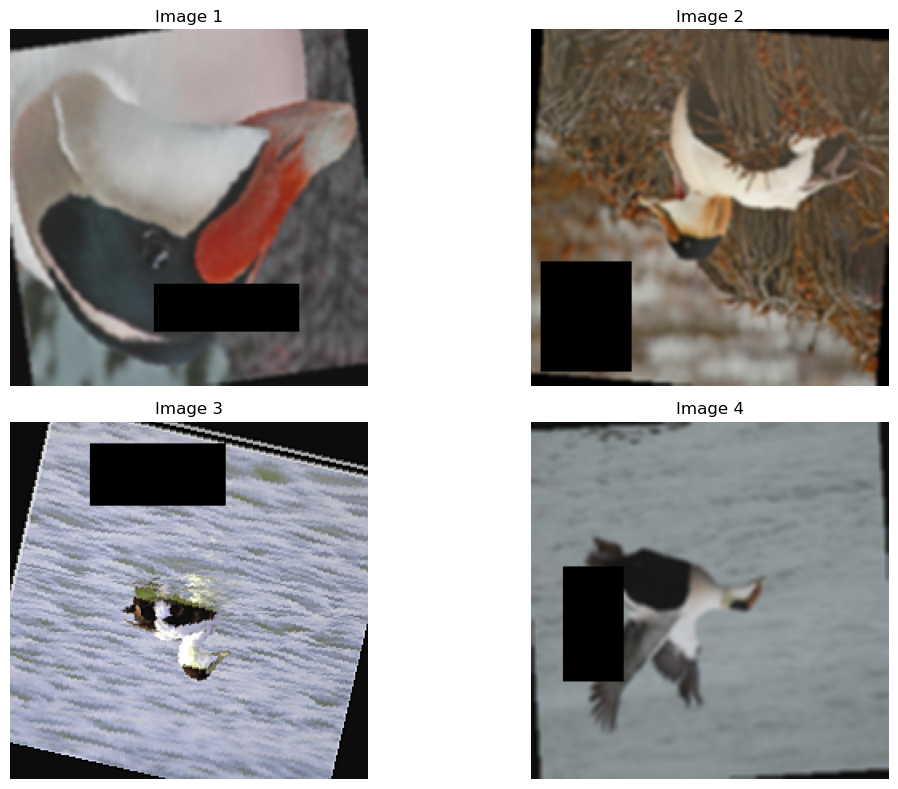

In [20]:
train_transform_view = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
                             
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomRotation(degrees=15),
    
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=1.0),
                     
    transforms.ToTensor(),

    transforms.RandomErasing(p=1.0, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
])

img_dir  = "../dataset/nabirds/versions/1/images/0295"

img_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

N = 4
img_files = img_files[:N]

cols = 2
rows = N // cols + int(N % cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))

for idx, img_fname in enumerate(img_files):
    pil = Image.open(os.path.join(img_dir, img_fname)).convert("RGB")

    out = train_transform_view(pil)
    out = out.squeeze(0).permute(1,2,0).cpu().numpy()

    r, c = divmod(idx, cols)
    ax = axes[r, c]
    ax.imshow(out)
    ax.set_title(f"Image {idx+1}")
    ax.axis("off")
    
plt.tight_layout()
plt.show()

# NABirds

## Dataset

In [21]:
class NABirdsDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, remap_labels=True):

        self.root = root_dir
        self.transform = transform

        self.id2path = {}
        with open(os.path.join(root_dir, "images.txt"), "r") as f:
            for line in f:
                parts = line.strip().split()
                
                if len(parts)!=2: continue
                    
                img_id, rel = parts
                self.id2path[img_id] = rel

        raw_id2label = {}
        with open(os.path.join(root_dir, "image_class_labels.txt"), "r") as f:
            for line in f:
                parts = line.strip().split()
                
                if len(parts)!=2: continue
                    
                img_id, cls = parts
                raw_id2label[img_id] = int(cls)

        flag_target = '1' if split=='train' else '0'
        raw_samples = []
        with open(os.path.join(root_dir, "train_test_split.txt"), "r") as f:
            for line in f:
                parts = line.strip().split()
                
                if len(parts)!=2: continue
                    
                img_id, flag = parts
                if flag==flag_target and img_id in self.id2path:
                    raw_samples.append((img_id, raw_id2label[img_id]))

        if remap_labels:
            unique_labels = sorted({lbl for _,lbl in raw_samples})

            self.label_map = {old: new for new, old in enumerate(unique_labels)}

            self.samples = [(img_id, self.label_map[lbl]) for img_id, lbl in raw_samples]
            self.num_classes = len(unique_labels)
        else:
            self.samples = raw_samples
            self.num_classes = len(sorted({lbl for _,lbl in raw_samples})) 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_id, label = self.samples[idx]
        img = Image.open(os.path.join(self.root, "images", self.id2path[img_id])).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

data_root = "../dataset/nabirds/versions/1"

train_dataset = NABirdsDataset(
    data_root,
    split='train',
    transform=train_transform
)

val_dataset = NABirdsDataset(
    data_root,
    split='val',
    transform=val_transform
)

In [22]:
print("Treino:", len(train_dataset), "amostras")
print("Validação:", len(val_dataset), "amostras")
print("Número de classes:", train_dataset.num_classes)

Treino: 23929 amostras
Validação: 24633 amostras
Número de classes: 555


## Dataloader

In [23]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=setup["batch_size"],
    shuffle=True,
    num_workers=setup["num_workers"],
    pin_memory=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=setup["batch_size"],
    shuffle=False,
    num_workers=setup["num_workers"],
    pin_memory=True
)

# Architecture

In [24]:
weights = models.ResNet50_Weights.IMAGENET1K_V1

net = models.resnet50(weights=weights)

for param in net.parameters():
    param.requires_grad = False

for name, param in net.layer4.named_parameters():
        param.requires_grad = True
    
net.fc = nn.Linear(net.fc.in_features, setup["num_classes"])

## View

In [25]:
print(net.fc)

Linear(in_features=2048, out_features=555, bias=True)


In [26]:
for name, param in net.named_parameters():
    if param.requires_grad == True:
        print(name, param.requires_grad)

layer4.0.conv1.weight True
layer4.0.bn1.weight True
layer4.0.bn1.bias True
layer4.0.conv2.weight True
layer4.0.bn2.weight True
layer4.0.bn2.bias True
layer4.0.conv3.weight True
layer4.0.bn3.weight True
layer4.0.bn3.bias True
layer4.0.downsample.0.weight True
layer4.0.downsample.1.weight True
layer4.0.downsample.1.bias True
layer4.1.conv1.weight True
layer4.1.bn1.weight True
layer4.1.bn1.bias True
layer4.1.conv2.weight True
layer4.1.bn2.weight True
layer4.1.bn2.bias True
layer4.1.conv3.weight True
layer4.1.bn3.weight True
layer4.1.bn3.bias True
layer4.2.conv1.weight True
layer4.2.bn1.weight True
layer4.2.bn1.bias True
layer4.2.conv2.weight True
layer4.2.bn2.weight True
layer4.2.bn2.bias True
layer4.2.conv3.weight True
layer4.2.bn3.weight True
layer4.2.bn3.bias True
fc.weight True
fc.bias True


In [27]:
summary(net, input_size=(setup['batch_size'], 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 555]                 --
├─Conv2d: 1-1                            [64, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        (128)
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [64, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [64, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [64, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [64, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [64, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [64, 64, 56, 56]   

# Criterion class weights

In [33]:
def calculate_class_weights():
    counts = Counter([lbl for _,lbl in train_dataset.samples])
    total = sum(counts.values())
    
    class_weights = [ total / counts[i] if counts[i]>0 else 0.0
                      for i in range(setup["num_classes"]) ]
    
    s = sum(class_weights)
    class_weights = [w/s for w in class_weights]

    return class_weights

# Train

In [29]:
def train(net, train_dataloader, val_dataloader, device, tensorboard_path):
  
    net.to(device)

    optimizer = torch.optim.SGD(
        filter(lambda p: p.requires_grad, net.parameters()),
        lr=setup['lr'],
        weight_decay=setup['weight_decay'],
        momentum=setup['momentum'])

    class_weights = calculate_class_weights()
    weight_tensor = tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=weight_tensor)
    
    # criterion = nn.CrossEntropyLoss()
    
    criterion.to(device)

    now = datetime.now()
    tensorboard_path = os.path.join(tensorboard_path, setup['experiment'] + '-' + now.strftime("%Y%m%d_%H%M%S"))
    
    writer = SummaryWriter(log_dir = tensorboard_path)
    writer.add_graph(net, next(iter(train_dataloader))[0].to(device))

    setup_path = os.path.join(tensorboard_path, 'setup.txt')
    with open(setup_path, 'w', encoding='utf-8') as f:
        json.dump(setup, f, indent=4, ensure_ascii=False, default=str)

    max_accuracy = -1.0

    for epoch in tqdm(range(setup['max_epochs'])):
        
        net.train()  

        train_loss, train_accuracy = [], []

        for train_batch in train_dataloader:
            
            train_x, train_label = train_batch
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            optimizer.zero_grad()

            outs = net(train_x)
    
            loss = criterion(outs, train_label)

            train_loss.append(loss.item())
            
            loss.backward()
            optimizer.step()

            predict_labels = torch.max(outs, axis=1)[1]
            correct = torch.sum(predict_labels == train_label).item()
            accuracy = correct/train_label.size(0)

            train_accuracy.append(accuracy)

            plot_net_attributes(epoch, net, writer)

        train_loss = np.asarray(train_loss)
        train_accuracy = np.asarray(train_accuracy)

        val_loss, val_accuracy = validate(net, criterion, val_dataloader, device)

        writer.add_scalar('Loss/train', train_loss.mean(), epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy.mean()*100., epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)
            
        if val_accuracy > max_accuracy:
            best_model = copy.deepcopy(net)
            max_accuracy = val_accuracy
            print(f'Salvando o modelo com melhor acurácia: {max_accuracy:3.2f}%')
            
        print(f'Época: {epoch+1:3d} | Loss/train: {train_loss.mean():3.4f}% | Accuracy/train: {train_accuracy.mean()*100.:3.4f}% |\
            Loss/val: {val_loss:3.4f}% | Accuracy/val: {val_accuracy:3.4f}% |')

    path = f'{models_path}/{setup["experiment"]}-{max_accuracy:.2f}.pkl'
    torch.save(best_model, path)
    print(f'Melhor modelo salvo em: {path}')

    writer.flush()
    writer.close()
    
    return best_model

# Validate

In [30]:
def validate(net, criterion, val_dataloader, device):

    net.eval()
    net.to(device)

    val_loss, val_accuracy = [], []

    for test_batch in val_dataloader:

        test_x, test_label = test_batch
        test_x = test_x.to(device)
        test_label = test_label.to(device)

        with torch.no_grad():
            outs = net(test_x).detach()

            loss = criterion(outs, test_label)
            
            val_loss.append(loss.item())
    
            predict_labels = torch.max(outs, axis=1)[1]
            correct = torch.sum(predict_labels == test_label).item()
            accuracy = correct/test_label.size(0)
    
            val_accuracy.append(accuracy)
        
    val_loss = np.asarray(val_loss)
    val_accuracy = np.asarray(val_accuracy)

    return val_loss.mean(), val_accuracy.mean()*100.

# Fit

In [34]:
best_model = train(net, train_dataloader, val_dataloader, device, tensorboard_path)

 50%|██████████████████████████████████████████████▌                                              | 1/2 [01:09<01:09, 69.66s/it]

Salvando o modelo com melhor acurácia: 3.05%
Época:   1 | Loss/train: 6.2332% | Accuracy/train: 0.7980% |            Loss/val: 5.8961% | Accuracy/val: 3.0529% |


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:55<00:00, 87.76s/it]

Salvando o modelo com melhor acurácia: 8.90%
Época:   2 | Loss/train: 5.7102% | Accuracy/train: 3.9140% |            Loss/val: 5.1343% | Accuracy/val: 8.8986% |
Melhor modelo salvo em: ./models/test_ResNet50_U-SGD-WCELoss-A-8.90.pkl
